The Following code is a Stacked LSTM with attention layers. Followed by a 128/64-1 regressor to get the next days price. I primarly use PyTorch for all the following models. The data is obtained from 2 different github repositories so that when they join there are no formating errors. The data is then filtered for the date and for tesla related information only. Distil bert is used along with its tokenizer and model from transformers. The data loaders are for batch runs note that the input is simply content for news and the normalized target. After training and testing the predicted prices are converted back and is used as a simple performance metric.

<ipython-input-1-0d421d88ecb9>:29: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  stock_df['Date'] = pd.to_datetime(stock_df['Date'])
<ipython-input-1-0d421d88ecb9>:33: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  news_df['Time'] = pd.to_datetime(news_df['Time'], errors='coerce')
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public mode

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Number of rows in train_df: 438
Number of rows in test_df: 190


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([22])) that is different to the input size (torch.Size([22, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/15 | Loss: 0.0029
Epoch 2/15 | Loss: 0.0024
Epoch 3/15 | Loss: 0.0021
Epoch 4/15 | Loss: 0.0019
Epoch 5/15 | Loss: 0.0018
Epoch 6/15 | Loss: 0.0018
Epoch 7/15 | Loss: 0.0017
Epoch 8/15 | Loss: 0.0017
Epoch 9/15 | Loss: 0.0017
Epoch 10/15 | Loss: 0.0017
Epoch 11/15 | Loss: 0.0017
Epoch 12/15 | Loss: 0.0017
Epoch 13/15 | Loss: 0.0018
Epoch 14/15 | Loss: 0.0017
Epoch 15/15 | Loss: 0.0017

Regression Metrics:
RMSE: 9.9935
MAE: 7.3422
R² Score: 0.9693


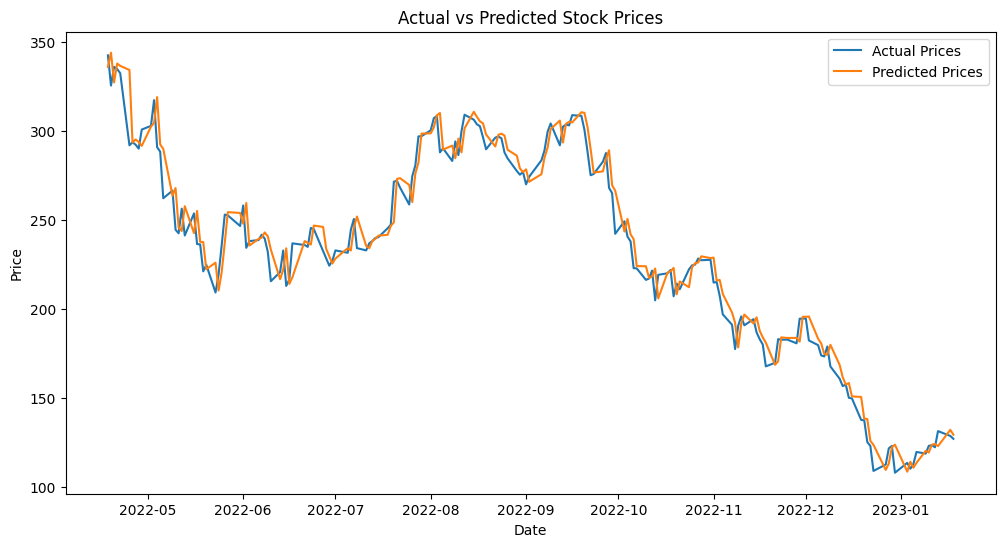

In [ ]:
# Step 2: Import necessary components
import torch
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from transformers import DistilBertTokenizer, DistilBertModel
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import torch.nn.functional as F  # For softmax
from torch.nn.utils.rnn import pad_sequence  # For padding handling

# ------------ Configuration ------------
TICKER = "TSLA"
START_DATE = pd.to_datetime('2021-07-15')
END_DATE = pd.to_datetime('2023-01-15')
MAX_SEQ_LENGTH = 128
BATCH_SIZE = 32


# Step 3: Create dataset (Fixed and improved)
def load_data():
    # Load stock data
    stock_df = pd.read_csv(
        'https://raw.githubusercontent.com/t-u-s-s-a-r/Tesla-Stock-Trading-Python/main/Tesla%20Stock%20Price%20(2010%20to%202023).csv'
    )
    stock_df['Date'] = pd.to_datetime(stock_df['Date'])

    # Load and process news data (fixed URL)
    news_df = pd.read_csv('https://raw.githubusercontent.com/EagleAdelaide/FinSen_Dataset/main/data.pptx/FinSen_US_Categorized_Timestamp.csv')
    news_df['Time'] = pd.to_datetime(news_df['Time'], errors='coerce')
    news_df = news_df.dropna(subset=['Time']).rename(columns={'Time': 'Date'})

    # Filter relevant news articles
    news_df = news_df[news_df['Content'].str.contains(rf'\b{TICKER}\b', case=False, na=False)]
    news_df = news_df.groupby('Date')['Content'].agg(' '.join).reset_index()

    # Merge datasets with look-ahead prevention
    merged_df = pd.merge_asof(
        stock_df.sort_values('Date'),
        news_df.sort_values('Date'),
        on='Date',
        direction='backward'
    ).dropna()

    # Create regression target (next day's closing price)
    merged_df['target'] = merged_df['Close'].shift(-1)
    merged_df = merged_df.dropna(subset=['target'])

    # Normalize prices and keep necessary columns
    merged_df['norm_target'] = (merged_df['target'] - merged_df['Close']) / merged_df['Close']
    return merged_df[['Date', 'Content', 'Close', 'target', 'norm_target']].dropna()

df = load_data()

# Step 4: Initialize tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Step 5: Modified Dataset class for regression
class StockDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = tokenizer(
            text,
            max_length=MAX_SEQ_LENGTH,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.float)  # Changed to float
        }

# Step 6: Split data and create dataloaders (Fixed time-based split)
# Time-based split
split_date = pd.to_datetime('2022-04-16')
train_df = df[df['Date'] < split_date]
test_df = df[df['Date'] >= split_date]
num_rows = len(train_df)
print(f"Number of rows in train_df: {num_rows}")
num_rows = len(test_df)
print(f"Number of rows in test_df: {num_rows}")

train_dataset = StockDataset(train_df['Content'].tolist(), train_df['norm_target'].tolist())
test_dataset = StockDataset(test_df['Content'].tolist(), test_df['norm_target'].tolist())

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Step 7: Modified model for LSTM with text processing
class TrueAttentionLSTM(nn.Module):
    def __init__(self, vocab_size, embed_size=128, hidden_size=128, num_layers=2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)

        # Stacked LSTM
        self.lstm = nn.LSTM(
            embed_size, hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=0.2 if num_layers > 1 else 0
        )

        # Attention Mechanism
        self.attention = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1, bias=False)
        )

        self.regressor = nn.Sequential(
            nn.Linear(hidden_size, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 1)
        )

    def forward(self, input_ids, attention_mask):
        embedded = self.embedding(input_ids)

        # Stacked LSTM
        outputs, _ = self.lstm(embedded)

        # Attention
        attn_scores = self.attention(outputs).squeeze(-1)
        attn_scores = attn_scores.masked_fill(attention_mask == 0, -1e9)
        attn_weights = F.softmax(attn_scores, dim=1).unsqueeze(2)
        context = torch.bmm(outputs.transpose(1,2), attn_weights).squeeze()

        return self.regressor(context)

model = TrueAttentionLSTM(vocab_size=tokenizer.vocab_size)



# Step 8: Training setup (Improved)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
optimizer = optim.AdamW(model.parameters(), lr=2e-5, weight_decay=1e-4)
loss_fn = nn.MSELoss()  # Changed to MSE loss

# Step 9: Training loop (Improved)
num_epochs = 15
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {total_loss/len(train_loader):.4f}")

# Step 10: Modified evaluation (fixed price conversion)
model.eval()
predictions, true_labels = [], []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids, attention_mask)
        predictions.extend(outputs.squeeze().cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Convert back to actual prices using test_df's Close prices
test_df = test_df.copy()
test_df['pred_change'] = predictions
test_df['pred_price'] = test_df['Close'] * (1 + test_df['pred_change'])
true_prices = test_df['target'].values

# Calculate metrics
rmse = np.sqrt(mean_squared_error(true_prices, test_df['pred_price']))
mae = mean_absolute_error(true_prices, test_df['pred_price'])
r2 = r2_score(true_prices, test_df['pred_price'])

print(f"\nRegression Metrics:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R² Score: {r2:.4f}")

# Additional visualization
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(test_df['Date'], true_prices, label='Actual Prices')
plt.plot(test_df['Date'], test_df['pred_price'], label='Predicted Prices')
plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

The only thing that was changed was the model,Frozen DistilBERT encoder to First Bi‑LSTM layer (768 → 256) to Second Bi‑LSTM layer (256 → 256) to Single self‑attention over the LSTM output to Regressor head (256 → 64 → 32 → 1). I also added Initialized regressor weights. In addition, the bert parameters are frozen until the third epoch for better performance.

<ipython-input-3-d645b83eb940>:29: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  stock_df['Date'] = pd.to_datetime(stock_df['Date'])
<ipython-input-3-d645b83eb940>:33: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  news_df['Time'] = pd.to_datetime(news_df['Time'], errors='coerce')


Number of rows in train_df: 438
Number of rows in test_df: 190


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([22])) that is different to the input size (torch.Size([22, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/15 | Loss: 0.1722 | LR: 2.00e-05
Epoch 2/15 | Loss: 0.0582 | LR: 2.00e-05
Epoch 3/15 | Loss: 0.0451 | LR: 2.00e-05
Epoch 4/15 | Loss: 0.0310 | LR: 2.00e-05
Epoch 5/15 | Loss: 0.0127 | LR: 2.00e-05
Epoch 6/15 | Loss: 0.0093 | LR: 2.00e-05
Epoch 7/15 | Loss: 0.0078 | LR: 2.00e-05
Epoch 8/15 | Loss: 0.0088 | LR: 2.00e-05
Epoch 9/15 | Loss: 0.0062 | LR: 2.00e-05
Epoch 10/15 | Loss: 0.0063 | LR: 2.00e-05
Epoch 11/15 | Loss: 0.0060 | LR: 1.00e-05
Epoch 12/15 | Loss: 0.0056 | LR: 1.00e-05
Epoch 13/15 | Loss: 0.0063 | LR: 1.00e-05
Epoch 14/15 | Loss: 0.0054 | LR: 5.00e-06
Epoch 15/15 | Loss: 0.0061 | LR: 5.00e-06

Regression Metrics:
RMSE: 9.7128
MAE: 7.1671
R² Score: 0.9710


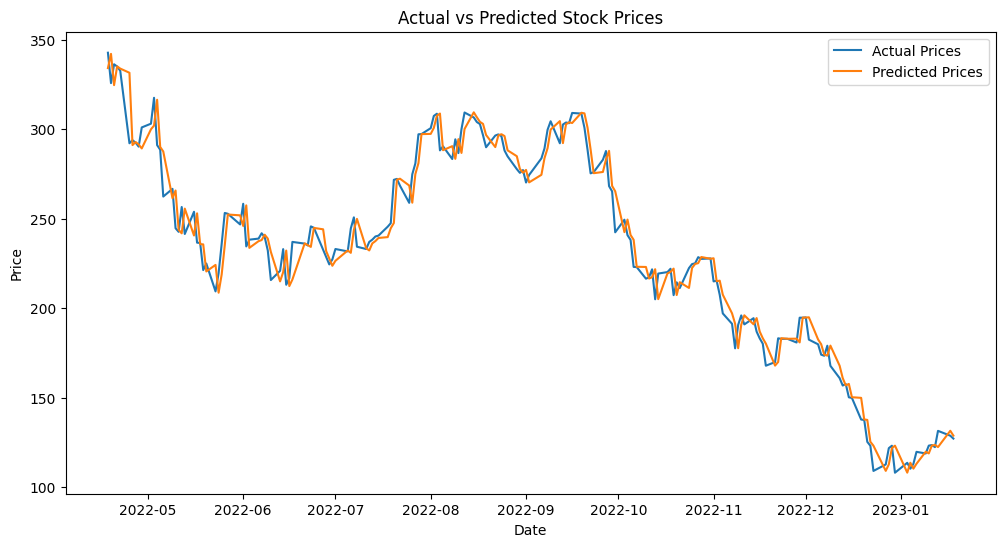

In [ ]:
# Step 2: Import necessary components
import torch
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from transformers import DistilBertTokenizer, DistilBertModel
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import torch.nn.functional as F  # For softmax
from torch.nn.utils.rnn import pad_sequence  # For padding handling

# ------------ Configuration ------------
TICKER = "TSLA"
START_DATE = pd.to_datetime('2021-07-15')   #can go to 2010
END_DATE = pd.to_datetime('2023-01-15')
MAX_SEQ_LENGTH = 128
BATCH_SIZE = 32


# Step 3: Create dataset (Fixed and improved)
def load_data():
    # Load stock data
    stock_df = pd.read_csv(
        'https://raw.githubusercontent.com/t-u-s-s-a-r/Tesla-Stock-Trading-Python/main/Tesla%20Stock%20Price%20(2010%20to%202023).csv'
    )
    stock_df['Date'] = pd.to_datetime(stock_df['Date'])

    # Load and process news data (fixed URL)
    news_df = pd.read_csv('https://raw.githubusercontent.com/EagleAdelaide/FinSen_Dataset/main/data.pptx/FinSen_US_Categorized_Timestamp.csv')
    news_df['Time'] = pd.to_datetime(news_df['Time'], errors='coerce')
    news_df = news_df.dropna(subset=['Time']).rename(columns={'Time': 'Date'})

    # Filter relevant news articles
    news_df = news_df[news_df['Content'].str.contains(rf'\b{TICKER}\b', case=False, na=False)]
    news_df = news_df.groupby('Date')['Content'].agg(' '.join).reset_index()

    # Merge datasets with look-ahead prevention
    merged_df = pd.merge_asof(
        stock_df.sort_values('Date'),
        news_df.sort_values('Date'),
        on='Date',
        direction='backward'
    ).dropna()

    # Create regression target (next day's closing price)
    merged_df['target'] = merged_df['Close'].shift(-1)
    merged_df = merged_df.dropna(subset=['target'])

    # Normalize prices and keep necessary columns
    merged_df['norm_target'] = (merged_df['target'] - merged_df['Close']) / merged_df['Close']
    return merged_df[['Date', 'Content', 'Close', 'target', 'norm_target']].dropna()

df = load_data()

# Step 4: Initialize tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Step 5: Modified Dataset class for regression
class StockDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = tokenizer(
            text,
            max_length=MAX_SEQ_LENGTH,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.float)  # Changed to float
        }

# Step 6: Split data and create dataloaders (Fixed time-based split)
# Time-based split
split_date = pd.to_datetime('2022-04-16')
train_df = df[df['Date'] < split_date]
test_df = df[df['Date'] >= split_date]
num_rows = len(train_df)
print(f"Number of rows in train_df: {num_rows}")
num_rows = len(test_df)
print(f"Number of rows in test_df: {num_rows}")

train_dataset = StockDataset(train_df['Content'].tolist(), train_df['norm_target'].tolist())
test_dataset = StockDataset(test_df['Content'].tolist(), test_df['norm_target'].tolist())

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)
# Step 7: Enhanced model architecture
class StackedLSTMWithAttention(nn.Module):
    def __init__(self):
        super().__init__()
        # 1) Frozen DistilBERT encoder
        self.bert = DistilBertModel.from_pretrained('distilbert-base-uncased')
        for p in self.bert.parameters():
            p.requires_grad = False

        # 2) First Bi‑LSTM layer (768 → 256)
        self.lstm1 = nn.LSTM(
            input_size=self.bert.config.dim,   # 768
            hidden_size=128,
            num_layers=1,
            bidirectional=True,
            batch_first=True,
            dropout=0.3
        )
        # 3) Second Bi‑LSTM layer (256 → 256)
        self.lstm2 = nn.LSTM(
            input_size=256,
            hidden_size=128,
            num_layers=1,
            bidirectional=True,
            batch_first=True,
            dropout=0.3
        )

        # 4) Single self‑attention over the LSTM output
        self.attention = nn.MultiheadAttention(
            embed_dim=256,
            num_heads=4,
            dropout=0.2,
            batch_first=True
        )

        # 5) Regressor head (256 → 64 → 64 → 1)
        self.regressor = nn.Sequential(
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.LayerNorm(32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

        # 6) Initialize regressor weights
        for m in self.regressor:
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)

    def forward(self, input_ids, attention_mask):
        # A) BERT embeddings → [B, T, 768]
        x = self.bert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state

        # B) First Bi‑LSTM → [B, T, 256]
        x, _ = self.lstm1(x)

        # C) Second Bi‑LSTM → [B, T, 256]
        x, _ = self.lstm2(x)

        # D) Self‑attention (queries=keys=values=x)
        attn_out, _ = self.attention(x, x, x, key_padding_mask=~attention_mask.bool())

        # E) Pool and residual
        context = attn_out.mean(dim=1)    # [B, 256]
        residual = x.mean(dim=1)          # [B, 256]
        combined = context + residual

        # F) Regress to a single scalar
        return self.regressor(combined)

# Step 8: Modified training setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = StackedLSTMWithAttention().to(device)
loss_fn = nn.MSELoss()  # Changed to MSE loss

optimizer = optim.AdamW(model.parameters(), lr=2e-5, weight_decay=1e-4)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=2
)

# Modified training loop
num_epochs = 15
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    # Gradually unfreeze BERT
    if epoch == 3:
        for param in model.bert.parameters():
            param.requires_grad = True

    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = loss_fn(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        total_loss += loss.item()

    scheduler.step(loss)
    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {total_loss/len(train_loader):.4f} | LR: {optimizer.param_groups[0]['lr']:.2e}")

# Step 10: Modified evaluation (fixed price conversion)
model.eval()
predictions, true_labels = [], []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids, attention_mask)
        predictions.extend(outputs.squeeze().cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Convert back to actual prices using test_df's Close prices
test_df = test_df.copy()
test_df['pred_change'] = predictions
test_df['pred_price'] = test_df['Close'] * (1 + test_df['pred_change'])
true_prices = test_df['target'].values

# Calculate metrics
rmse = np.sqrt(mean_squared_error(true_prices, test_df['pred_price']))
mae = mean_absolute_error(true_prices, test_df['pred_price'])
r2 = r2_score(true_prices, test_df['pred_price'])

print(f"\nRegression Metrics:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R² Score: {r2:.4f}")

# Additional visualization
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(test_df['Date'], true_prices, label='Actual Prices')
plt.plot(test_df['Date'], test_df['pred_price'], label='Predicted Prices')
plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

The Following code is the BERT model, it goes from bert to dropout and finally to Regressor head 768/256->1.

<ipython-input-6-e75e93884556>:29: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  stock_df['Date'] = pd.to_datetime(stock_df['Date'])
<ipython-input-6-e75e93884556>:33: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  news_df['Time'] = pd.to_datetime(news_df['Time'], errors='coerce')


Number of rows in train_df: 438
Number of rows in test_df: 190


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([22])) that is different to the input size (torch.Size([22, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/5 | Loss: 0.0077
Epoch 2/5 | Loss: 0.0029
Epoch 3/5 | Loss: 0.0023
Epoch 4/5 | Loss: 0.0021
Epoch 5/5 | Loss: 0.0021

Regression Metrics:
RMSE: 9.8067
MAE: 7.1878
R² Score: 0.9704


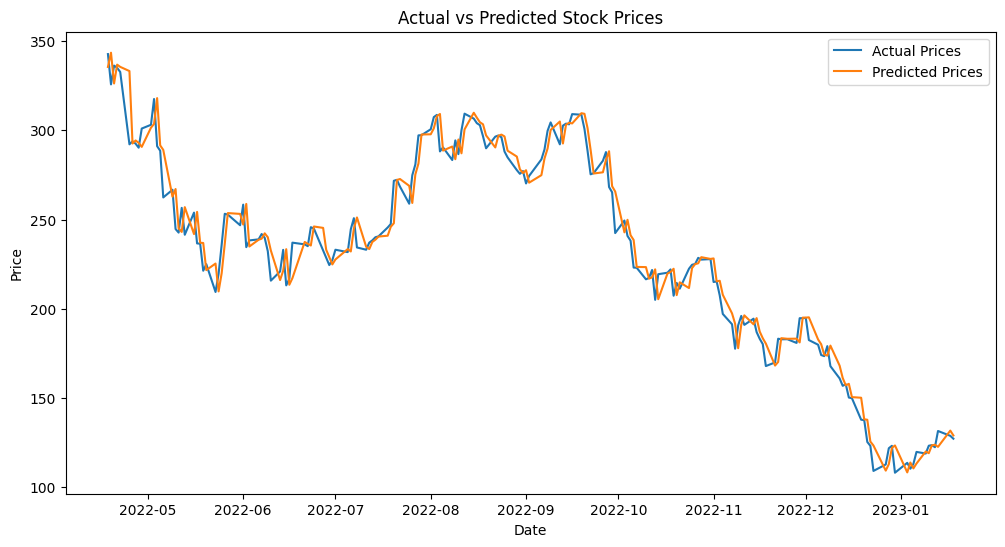

In [ ]:
# Step 2: Import necessary components
import torch
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from transformers import DistilBertTokenizer, DistilBertModel
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import torch.nn.functional as F  # For softmax
from torch.nn.utils.rnn import pad_sequence  # For padding handling

# ------------ Configuration ------------
TICKER = "TSLA"
START_DATE = pd.to_datetime('2021-07-15')   #can go to 2010
END_DATE = pd.to_datetime('2023-01-15')
MAX_SEQ_LENGTH = 128
BATCH_SIZE = 32


# Step 3: Create dataset (Fixed and improved)
def load_data():
    # Load stock data
    stock_df = pd.read_csv(
        'https://raw.githubusercontent.com/t-u-s-s-a-r/Tesla-Stock-Trading-Python/main/Tesla%20Stock%20Price%20(2010%20to%202023).csv'
    )
    stock_df['Date'] = pd.to_datetime(stock_df['Date'])

    # Load and process news data (fixed URL)
    news_df = pd.read_csv('https://raw.githubusercontent.com/EagleAdelaide/FinSen_Dataset/main/data.pptx/FinSen_US_Categorized_Timestamp.csv')
    news_df['Time'] = pd.to_datetime(news_df['Time'], errors='coerce')
    news_df = news_df.dropna(subset=['Time']).rename(columns={'Time': 'Date'})

    # Filter relevant news articles
    news_df = news_df[news_df['Content'].str.contains(rf'\b{TICKER}\b', case=False, na=False)]
    news_df = news_df.groupby('Date')['Content'].agg(' '.join).reset_index()

    # Merge datasets with look-ahead prevention
    merged_df = pd.merge_asof(
        stock_df.sort_values('Date'),
        news_df.sort_values('Date'),
        on='Date',
        direction='backward'
    ).dropna()

    # Create regression target (next day's closing price)
    merged_df['target'] = merged_df['Close'].shift(-1)
    merged_df = merged_df.dropna(subset=['target'])

    # Normalize prices and keep necessary columns
    merged_df['norm_target'] = (merged_df['target'] - merged_df['Close']) / merged_df['Close']
    return merged_df[['Date', 'Content', 'Close', 'target', 'norm_target']].dropna()

df = load_data()

# Step 4: Initialize tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Step 5: Modified Dataset class for regression
class StockDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = tokenizer(
            text,
            max_length=MAX_SEQ_LENGTH,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.float)  # Changed to float
        }

# Step 6: Split data and create dataloaders (Fixed time-based split)
# Time-based split
split_date = pd.to_datetime('2022-04-16')
train_df = df[df['Date'] < split_date]
test_df = df[df['Date'] >= split_date]
num_rows = len(train_df)
print(f"Number of rows in train_df: {num_rows}")
num_rows = len(test_df)
print(f"Number of rows in test_df: {num_rows}")

train_dataset = StockDataset(train_df['Content'].tolist(), train_df['norm_target'].tolist())
test_dataset = StockDataset(test_df['Content'].tolist(), test_df['norm_target'].tolist())

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)
# Step 7: BERT-only model
class StockPredictor(nn.Module):
    def __init__(self):
        super().__init__()
        self.bert = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.dropout = nn.Dropout(0.2)
        self.regressor = nn.Sequential(
            nn.Linear(self.bert.config.dim, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 1)
        )

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        hidden_state = outputs.last_hidden_state[:, 0]  # CLS token
        x = self.dropout(hidden_state)
        return self.regressor(x)

# Initialize model
model = StockPredictor().to(device)


optimizer = optim.AdamW(model.parameters(), lr=2e-5, weight_decay=1e-5)

num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = loss_fn(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {total_loss/len(train_loader):.4f}")

# Step 10: Modified evaluation (fixed price conversion)
model.eval()
predictions, true_labels = [], []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids, attention_mask)
        predictions.extend(outputs.squeeze().cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Convert back to actual prices using test_df's Close prices
test_df = test_df.copy()
test_df['pred_change'] = predictions
test_df['pred_price'] = test_df['Close'] * (1 + test_df['pred_change'])
true_prices = test_df['target'].values

# Calculate metrics
rmse = np.sqrt(mean_squared_error(true_prices, test_df['pred_price']))
mae = mean_absolute_error(true_prices, test_df['pred_price'])
r2 = r2_score(true_prices, test_df['pred_price'])

print(f"\nRegression Metrics:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R² Score: {r2:.4f}")

# Additional visualization
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(test_df['Date'], true_prices, label='Actual Prices')
plt.plot(test_df['Date'], test_df['pred_price'], label='Predicted Prices')
plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()